In [3]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
from google.colab import data_table
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold,train_test_split
from scipy.stats import randint, uniform, pointbiserialr
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import time

In [4]:
project_id = "test-ga4-project-workshop"
client = bigquery.Client(project=project_id)
query = """
SELECT *
FROM `test-ga4-project-workshop.analytics_310761705.Capstone_Final_Project`
"""
df = client.query(query).to_dataframe()


In [5]:
df['start_dt'] = pd.to_datetime(df['Start_time'], unit='us', errors='coerce')
df['weekday'] = df['start_dt'].dt.weekday   # Monday=0 ... Sunday=6
df['session_hour'] = df['start_dt'].dt.hour
df['session_duration_sec'] = df['session_duration'] / 1e6


In [7]:
y = df['purchased'].astype(int)

numeric_cols = ['item_price', 'session_duration_sec', 'event_count', 'weekday','session_hour']
numeric_cols = [c for c in numeric_cols if c in df.columns]

num_corr_rows = []
for col in numeric_cols:
    x = pd.to_numeric(df[col], errors='coerce')
    m = x.notna() & y.notna()
    if m.sum() > 1 and x[m].nunique() > 1:
        r, p = pointbiserialr(y[m], x[m])
        num_corr_rows.append({
            'feature': col,
            'type': 'numeric',
            'corr': r,
            'p_value': p,
            'n': int(m.sum())
        })

num_corr = pd.DataFrame(num_corr_rows)

cat_cols = ['item_category', 'device_category', 'traffic_source_group', 'customer_type']
dummies = pd.get_dummies(df[cat_cols].astype('category'), dummy_na=False, drop_first=False)

cat_corr_rows = []
for col in dummies.columns:
    x = dummies[col].astype(int)
    m = x.notna() & y.notna()
    n = int(m.sum())
    if n > 1 and x[m].nunique() > 1:
        r, p = pointbiserialr(y[m], x[m])
        cat_corr_rows.append({
            'feature': col,
            'type': 'categorical',
            'corr': r,
            'p_value': p,
            'n': n
        })

cat_corr = pd.DataFrame(cat_corr_rows)

all_corr = pd.concat([num_corr, cat_corr], ignore_index=True)
all_corr['abs_corr'] = all_corr['corr'].abs()

all_corr = all_corr.sort_values('abs_corr', ascending=False)

print(all_corr[['feature','type','corr','p_value','n']].to_string(index=False))

                                                                               feature        type      corr       p_value        n
                                                             customer_type_notLoggedIn categorical -0.386604  0.000000e+00 10248563
                                                               customer_type_corporate categorical  0.338601  0.000000e+00 10248563
                                                                     customer_type_web categorical  0.170808  0.000000e+00 10248563
                                                               device_category_desktop categorical  0.155763  0.000000e+00 10248563
                                                                device_category_mobile categorical -0.154073  0.000000e+00 10248563
                                                             item_category_Work Gloves categorical  0.081976  0.000000e+00 10248563
                                                         traffic_source_grou


[LOGIT] Top positive features (more likely to purchase):
                          feature     coef  odds_ratio
                  session_hour_16 0.661204    1.937122
                customer_type_web 0.609575    1.839649
                  session_hour_17 0.588169    1.800689
                  session_hour_14 0.585390    1.795691
                  session_hour_19 0.583228    1.791812
                  session_hour_15 0.573283    1.774082
                  session_hour_18 0.572792    1.773211
                  session_hour_13 0.541928    1.719319
                  session_hour_12 0.469623    1.599392
                  session_hour_20 0.449600    1.567685
item_category_slim_Safety Eyewear 0.447267    1.564032
                  session_hour_23 0.361750    1.435840
                      event_count 0.327811    1.387926
                  session_hour_22 0.304683    1.356195
   item_category_slim_Work Gloves 0.303025    1.353948

[LOGIT] Top negative features (less likely to purchase):
    

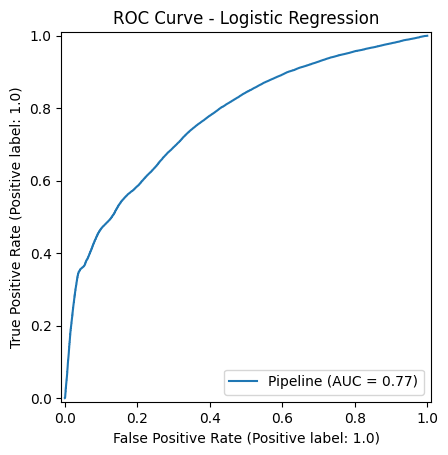

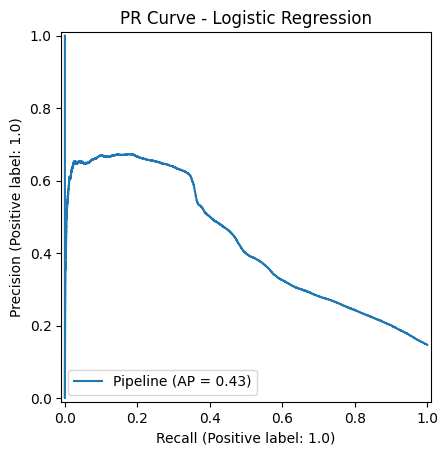

In [7]:

target_col = 'purchased'
numeric_feats = ['item_price','session_duration_sec','event_count']
cat_feats = ['weekday','item_category_slim','device_category','traffic_source_group','customer_type']

X = df[numeric_feats + cat_feats]
y = df[target_col]
X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = OneHotEncoder(
    handle_unknown='ignore',
    drop='first',
    sparse_output=False
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feats),
        ('cat', cat_transformer, cat_feats)
    ],
    remainder='drop'
)

logit = LogisticRegression(
    penalty='l1', solver='liblinear', max_iter=200,
    class_weight='balanced'
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', logit)
])

clf.fit(X_train, y_train)


oh: OneHotEncoder = clf.named_steps['prep'].named_transformers_['cat']
cat_feature_names = oh.get_feature_names_out(cat_feats).tolist()
feature_names = numeric_feats + cat_feature_names

coefs = clf.named_steps['clf'].coef_.ravel()
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
    'odds_ratio': np.exp(coefs)
}).sort_values('coef', ascending=False)

print("\n[LOGIT] Top positive features (more likely to purchase):")
print(coef_df.head(15).to_string(index=False))
print("\n[LOGIT] Top negative features (less likely to purchase):")
print(coef_df.tail(15).to_string(index=False))




y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\n[LOGIT] Accuracy :", accuracy_score(y_test, y_pred))
print("[LOGIT] Precision:", precision_score(y_test, y_pred))
print("[LOGIT] Recall   :", recall_score(y_test, y_pred))
print("[LOGIT] F1       :", f1_score(y_test, y_pred))
print("[LOGIT] ROC-AUC  :", roc_auc_score(y_test, y_prob))
print("[LOGIT] PR-AUC   :", average_precision_score(y_test, y_prob))

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
plt.title("PR Curve - Logistic Regression")
plt.show()

/tmp/ipython-input-2088302771.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="odds_ratio", y="feature", data=plot_df, palette="vlag")


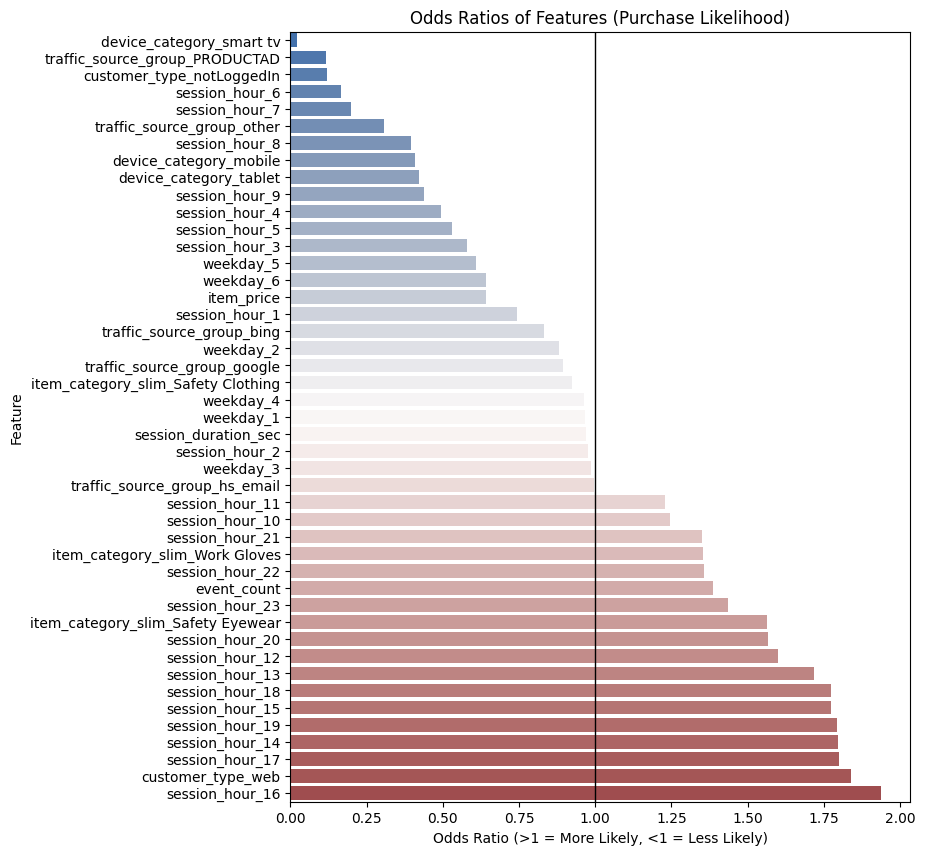

In [9]:
plot_df = coef_df.sort_values("odds_ratio", ascending=True)

plt.figure(figsize=(8,10))
sns.barplot(x="odds_ratio", y="feature", data=plot_df, palette="vlag")
plt.axvline(1, color="black", linewidth=1)
plt.title("Odds Ratios of Features (Purchase Likelihood)")
plt.xlabel("Odds Ratio (>1 = More Likely, <1 = Less Likely)")
plt.ylabel("Feature")
plt.show()

/tmp/ipython-input-4187370368.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


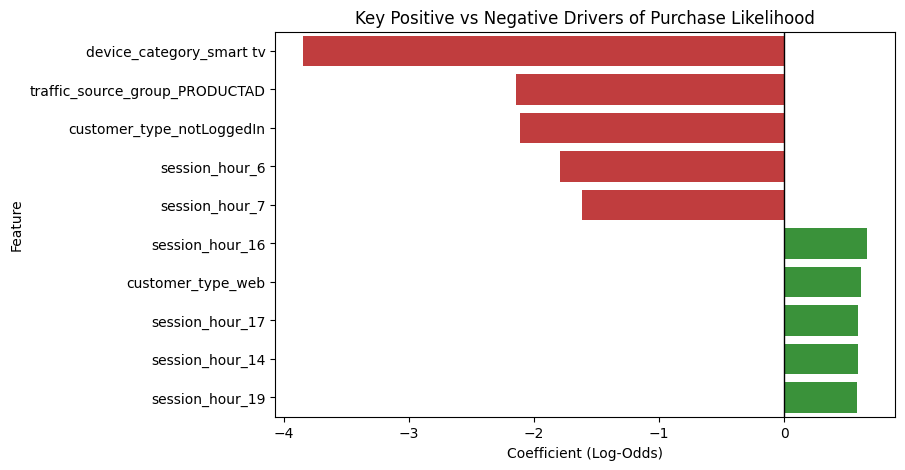

In [10]:
top_pos = coef_df.sort_values("coef", ascending=False).head(5)
top_neg = coef_df.sort_values("coef", ascending=True).head(5)

plot_df = pd.concat([top_neg, top_pos])

plt.figure(figsize=(8,5))
sns.barplot(
    x="coef", y="feature",
    data=plot_df,
    palette=["#d62728" if v < 0 else "#2ca02c" for v in plot_df["coef"]]
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Key Positive vs Negative Drivers of Purchase Likelihood")
plt.xlabel("Coefficient (Log-Odds)")
plt.ylabel("Feature")
plt.show()

[Info] Final feature count after One-Hot: 50

[FAST RF] Accuracy : 0.78945
[FAST RF] Precision: 0.4682246250435996
[FAST RF] Recall   : 0.893622686726135
[FAST RF] F1       : 0.6144832005859197
[FAST RF] ROC-AUC  : 0.9132159409860827
[FAST RF] PR-AUC   : 0.6953221680022561

[FAST RF] Confusion Matrix:
 [[24866  7623]
 [  799  6712]]

[FAST RF] Classification Report:
               precision    recall  f1-score   support

           0      0.969     0.765     0.855     32489
           1      0.468     0.894     0.614      7511

    accuracy                          0.789     40000
   macro avg      0.719     0.829     0.735     40000
weighted avg      0.875     0.789     0.810     40000


[FAST RF] Top-10 Feature Importances:
                   feature  importance
               event_count    0.374089
      session_duration_sec    0.202978
                item_price    0.104398
 customer_type_notLoggedIn    0.100126
   customer_type_corporate    0.080429
   device_category_desktop    

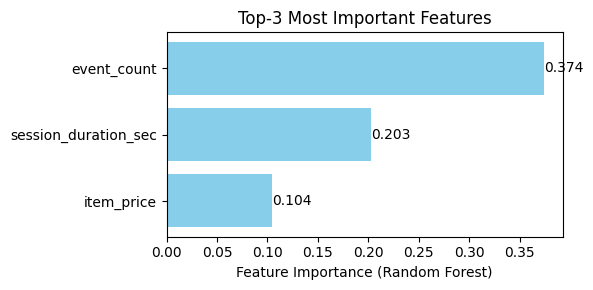

In [10]:
# ===== Fast Random Forest: quick run with capped features =====

t0 = time.time()

target_col    = 'purchased'
numeric_feats = ['item_price','session_duration_sec','event_count']
cat_feats     = ['weekday','item_category_slim','device_category','traffic_source_group','customer_type','session_hour']

df_use = df[numeric_feats + cat_feats + [target_col]].copy()
df_use[target_col] = df_use[target_col].astype(int)


MAX_ROWS = 200_000
if len(df_use) > MAX_ROWS:
    df_use = df_use.sample(n=MAX_ROWS, random_state=42)

min_count = 1000
for c in cat_feats:
    vc = df_use[c].astype('category').value_counts(dropna=False)
    rare = set(vc[vc < min_count].index)
    df_use[c] = np.where(df_use[c].isin(rare), 'Other', df_use[c].astype(str))


X = df_use[numeric_feats + cat_feats]
y = df_use[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False))
])
prep = ColumnTransformer([
    ('num', num_tf, numeric_feats),
    ('cat', cat_tf, cat_feats)
], remainder='drop')


rf = RandomForestClassifier(
    n_estimators=80,
    max_depth=12,
    min_samples_leaf=20,
    max_features='sqrt',
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([('prep', prep), ('rf', rf)])


prep.fit(X_train)
ohe = prep.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_feats).tolist()
feature_names = numeric_feats + cat_feature_names
print(f"[Info] Final feature count after One-Hot: {len(feature_names):,}")


pipe.fit(X_train, y_train)


proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print("\n[FAST RF] Accuracy :", accuracy_score(y_test, pred))
print("[FAST RF] Precision:", precision_score(y_test, pred, zero_division=0))
print("[FAST RF] Recall   :", recall_score(y_test, pred))
print("[FAST RF] F1       :", f1_score(y_test, pred))
print("[FAST RF] ROC-AUC  :", roc_auc_score(y_test, proba))
print("[FAST RF] PR-AUC   :", average_precision_score(y_test, proba))
print("\n[FAST RF] Confusion Matrix:\n", confusion_matrix(y_test, pred))
print("\n[FAST RF] Classification Report:\n", classification_report(y_test, pred, digits=3))


importances = pipe.named_steps['rf'].feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances}) \
        .sort_values('importance', ascending=False)
print("\n[FAST RF] Top-10 Feature Importances:")
print(fi.head(10).to_string(index=False))

print(f"\nDone in {time.time()-t0:.1f}s")



import matplotlib.pyplot as plt

top3 = fi.head(3).iloc[::-1]

plt.figure(figsize=(6,3))
plt.barh(top3['feature'], top3['importance'], color='skyblue')
plt.xlabel('Feature Importance (Random Forest)')
plt.title('Top-3 Most Important Features')
for i, v in enumerate(top3['importance']):
    plt.text(v, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits

[RS] Best params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 15, 'rf__max_features': 0.5, 'rf__max_samples': np.float64(0.8950877702656028), 'rf__min_samples_leaf': 14, 'rf__n_estimators': 120, 'rf__oob_score': True}
[RS] CV best score (PR-AUC): 0.735761015188011

[RS] Chosen threshold for best F1: 0.650
[RS] Accuracy : 0.875875
[RS] Precision: 0.6425851254480287
[RS] Recall   : 0.7638130741579018
[RS] F1       : 0.6979743293387676
[RS] ROC-AUC  : 0.9294568690268669
[RS] PR-AUC   : 0.7543158592141199

[RS] Confusion Matrix:
 [[29298  3191]
 [ 1774  5737]]

[RS] Classification Report:
               precision    recall  f1-score   support

           0      0.943     0.902     0.922     32489
           1      0.643     0.764     0.698      7511

    accuracy                          0.876     40000
   macro avg      0.793     0.833     0.810     40000
weighted avg      0.887     0.876 

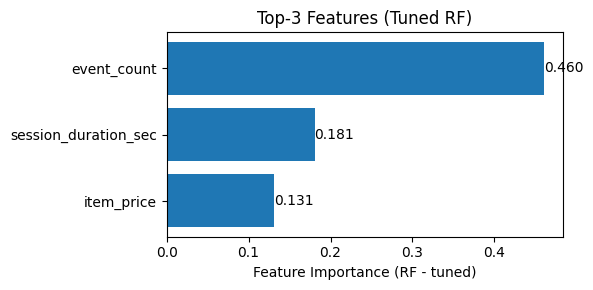

In [13]:
param_dist = {
    'rf__n_estimators':      randint(80, 220),
    'rf__max_depth':         randint(8, 20),
    'rf__min_samples_leaf':  randint(10, 60),
    'rf__max_features':      ['sqrt', 'log2', 0.5, 0.7],
    'rf__bootstrap':         [True],
    'rf__oob_score':         [True],
    'rf__max_samples':       uniform(0.5, 0.5),
    'rf__class_weight':      ['balanced_subsample']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring='average_precision',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)
best_pipe = rs.best_estimator_
print("\n[RS] Best params:", rs.best_params_)
print("[RS] CV best score (PR-AUC):", rs.best_score_)


proba_rs = best_pipe.predict_proba(X_test)[:, 1]

from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y_test, proba_rs)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = f1_scores.argmax()
best_thr = thr[max(best_idx-1, 0)] if len(thr) > 0 else 0.5

pred_rs = (proba_rs >= best_thr).astype(int)

print(f"\n[RS] Chosen threshold for best F1: {best_thr:.3f}")
print("[RS] Accuracy :", accuracy_score(y_test, pred_rs))
print("[RS] Precision:", precision_score(y_test, pred_rs, zero_division=0))
print("[RS] Recall   :", recall_score(y_test, pred_rs))
print("[RS] F1       :", f1_score(y_test, pred_rs))
print("[RS] ROC-AUC  :", roc_auc_score(y_test, proba_rs))
print("[RS] PR-AUC   :", average_precision_score(y_test, proba_rs))
print("\n[RS] Confusion Matrix:\n", confusion_matrix(y_test, pred_rs))
print("\n[RS] Classification Report:\n", classification_report(y_test, pred_rs, digits=3))

# Top-10
ohe = best_pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_feats).tolist()
feature_names = numeric_feats + cat_feature_names
imp = best_pipe.named_steps['rf'].feature_importances_
fi_best = pd.DataFrame({'feature': feature_names, 'importance': imp}).sort_values('importance', ascending=False)
print("\n[RS] Top-10 Feature Importances:")
print(fi_best.head(10).to_string(index=False))

# Top-3
import matplotlib.pyplot as plt
top3 = fi_best.head(3).iloc[::-1]
plt.figure(figsize=(6,3))
plt.barh(top3['feature'], top3['importance'])
plt.xlabel('Feature Importance (RF - tuned)')
plt.title('Top-3 Features (Tuned RF)')
for i, v in enumerate(top3['importance']):
    plt.text(v, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.show()